In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.ticker as mtick
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from joblib import dump

In [2]:
# ------------------------------------------
# (1) 设置随机种子以保证可复现
# ------------------------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [3]:
# ------------------------------------------
# (2) 定义 ResNet 结构（同你给出的代码）
# ------------------------------------------
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out

In [6]:
res = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/fine_tune_grid_results.csv')
best_param_df = res.sort_values(['set_point', 'R2'], ascending=[True, False]).groupby('set_point').head(1)
best_param_dict = {row['set_point']: {'batch_size': row['batch_size'], 'num_epochs': row['num_epochs']} 
                   for idx, row in best_param_df.iterrows()}
set_points = [0.1, 0.2, 0.4, 0.8, 1.0]

finetune_params = {
    0.1: {'hidden_size': 1024, 'num_blocks': 10, 'learning_rate': 0.000530435797934885,  'num_frozen_blocks': 7,  'weight_decay':  0.008497148468566256},
    0.2: {'hidden_size': 1024, 'num_blocks': 19, 'learning_rate': 0.0009907214001954557,  'num_frozen_blocks': 15, 'weight_decay': 0.0008450232969616185},
    0.4: {'hidden_size': 1024, 'num_blocks': 13, 'learning_rate': 0.0008399151983819402,  'num_frozen_blocks': 12, 'weight_decay': 0.0012652607042064328},
    0.8: {'hidden_size': 1024, 'num_blocks': 20, 'learning_rate': 0.0009661785734282122, 'num_frozen_blocks': 18, 'weight_decay':  0.0005279042637155721},
    1.0: {'hidden_size': 1024, 'num_blocks': 11, 'learning_rate': 0.0005540192611872995,  'num_frozen_blocks': 9,  'weight_decay': 0.0009568555327884106}
}

for sp in set_points:
    params = finetune_params[sp]
    params['batch_size'] = int(best_param_dict[sp]['batch_size'])
    params['num_epochs'] = int(best_param_dict[sp]['num_epochs'])

(pd.DataFrame(finetune_params)).T

,hidden_size,num_blocks,learning_rate,num_frozen_blocks,weight_decay,batch_size,num_epochs
0.1,1024.0,10.0,0.000530,7.0,0.008497,16.0,50.0
0.2,1024.0,19.0,0.000991,15.0,0.000845,32.0,50.0
0.4,1024.0,13.0,0.000840,12.0,0.001265,16.0,50.0
0.8,1024.0,20.0,0.000966,18.0,0.000528,8.0,50.0
1.0,1024.0,11.0,0.000554,9.0,0.000957,16.0,50.0


In [15]:
# set_points = [0.1, 0.2, 0.4, 0.8, 1.0]

# finetune_params = {
#     0.1: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 10, 'learning_rate': 0.000530435797934885,  'num_frozen_blocks': 7,  'weight_decay':  0.008497148468566256,  'num_epochs': 30},
#     0.2: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 19, 'learning_rate': 0.0009907214001954557,  'num_frozen_blocks': 15, 'weight_decay': 0.0008450232969616185, 'num_epochs': 30},
#     0.4: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 13, 'learning_rate': 0.0008399151983819402,  'num_frozen_blocks': 12, 'weight_decay': 0.0012652607042064328, 'num_epochs': 30},
#     0.8: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 20, 'learning_rate': 0.0009661785734282122, 'num_frozen_blocks': 18, 'weight_decay':  0.0005279042637155721, 'num_epochs': 30},
#     1.0: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 11, 'learning_rate': 0.0005540192611872995,  'num_frozen_blocks': 9,  'weight_decay': 0.0009568555327884106, 'num_epochs': 30}
# }

In [16]:
# ====================================
# (4) 只在 PartMC 原始训练集上 fit 一次 StandardScaler
# ====================================
features = ['Temperature', 'RH', 'Bulk_DP', 'Num_Conc', 'OA', 'SO4', 'Cl', 'NH4', 'NO3']
partmc_train_path = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/partmc_train.csv'
partmc_train_data = pd.read_csv(partmc_train_path)
X_partmc = partmc_train_data[features].values

scaler_X = StandardScaler()
scaler_X.fit(X_partmc)
dump(scaler_X, '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/fine_tune_scaler_X.joblib')

# ====================================
# (5) 定义微调函数：加载数据 → 构建模型 → 冻结层 → 训练 → 保存
# ====================================
def finetune_for_setpoint(set_point, params):
    print(f"\n>>> Fine-tuning S={set_point}: {params}")

    # 加载 ARM train/test
    train_path = f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/setpoint_{set_point}_train.csv'
    test_path  = f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/setpoint_{set_point}_test.csv'
    arm_train = pd.read_csv(train_path)
    arm_test  = pd.read_csv(test_path)

    X_train = scaler_X.transform(arm_train[features].values)
    y_train = arm_train['N_CCN'].values
    # （test 集无需在微调时使用，但可留作后续评估）
    X_test = scaler_X.transform(arm_test[features].values)
    y_test  = arm_test['N_CCN'].values

    # DataLoader
    train_dataset = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True
    )

    # 构建模型 & 加载 Foundation 权重
    model = ResNet(
        in_features=len(features),
        num_blocks=params['num_blocks'],
        hidden_size=params['hidden_size']
    )
    foundation_path = f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/Foundation_Model_{set_point}.pth'
    model.load_state_dict(torch.load(foundation_path))

    # 冻结层
    for idx, block in enumerate(model.blocks):
        if idx < params['num_frozen_blocks']:
            for p in block.parameters():
                p.requires_grad = False

    # 损失与优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )

    # 训练循环
    best_mse = float('inf')
    best_state = None
    for epoch in range(params['num_epochs']):
        model.train()
        running_loss = 0.0
        for X_b, y_b in train_loader:
            optimizer.zero_grad()
            out = model(X_b).view(-1)
            loss = criterion(out, y_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            running_loss += loss.item() * X_b.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        if epoch_loss < best_mse:
            best_mse = epoch_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        print(f"  Epoch {epoch+1}/{params['num_epochs']}, Train Loss = {epoch_loss:.6f}")

    # 保存最优权重
    model.load_state_dict(best_state)
    save_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/'
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f'resnet_finetuned_{set_point}.pth')
    torch.save(model.state_dict(), save_path)
    print(f"  Saved best model (MSE={best_mse:.6f}) → {save_path}")

In [17]:
# ====================================
# (6) 对所有 set_point 执行微调
# ====================================
for sp, params in finetune_params.items():
    finetune_for_setpoint(sp, params)


>>> 处理 set_point = 0.1
  MSE = 7139.9218, RMSE = 84.4981, R² = 0.5922, MAPE = 56.1%

>>> 处理 set_point = 0.2
  MSE = 30834.7732, RMSE = 175.5983, R² = 0.7573, MAPE = 34.3%

>>> 处理 set_point = 0.4
  MSE = 67459.1418, RMSE = 259.7290, R² = 0.8031, MAPE = 27.6%

>>> 处理 set_point = 0.8
  MSE = 151609.8107, RMSE = 389.3710, R² = 0.7818, MAPE = 37.4%

>>> 处理 set_point = 1.0
  MSE = 293222.0695, RMSE = 541.4998, R² = 0.7081, MAPE = 43.7%


/tmp/ipykernel_63919/3977118574.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


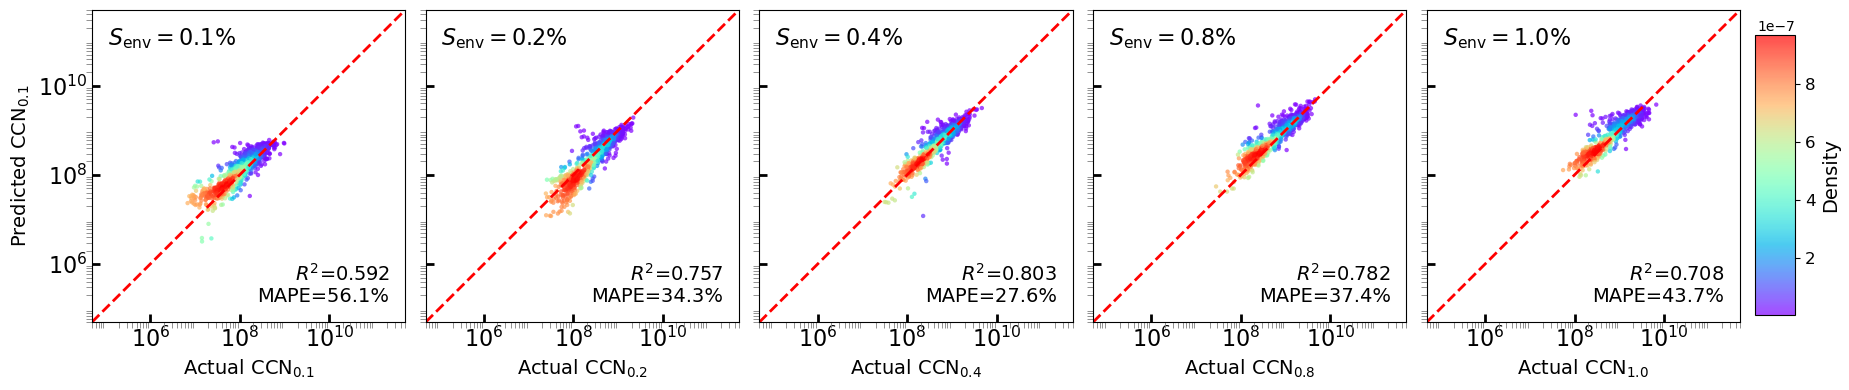

In [7]:
from joblib import load
scaler_X = load('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/fine_tune_scaler_X.joblib')

# ================================================
# (4) 创建 1×5 的 subplots，准备按顺序绘制每个 set_point
# ================================================
xmin, xmax = 5e4, 5e11
ymin, ymax = 5e4, 5e11

fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
scatter_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for i, sp in enumerate(set_points):
    ax = axes[i]
    print(f"\n>>> 处理 set_point = {sp}")

    # ----------------------------------------
    # (4.1) 实例化与微调时相同结构的模型，并加载对应权重
    # ----------------------------------------
    num_blocks  = finetune_params[sp]['num_blocks']
    hidden_size = finetune_params[sp]['hidden_size']
    in_features = len(features)

    model = ResNet(in_features, num_blocks, hidden_size).to(device)
    model_path = f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/resnet_finetuned_{sp}.pth'
    if not os.path.isfile(model_path):
        print(f"模型文件 {model_path} 不存在，跳过 {sp}")
        continue

    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # ----------------------------------------
    # (4.2) 加载对应的测试集 CSV 并做归一化
    # ----------------------------------------
    test_csv = f'/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/setpoint_{sp}_test.csv'
    if not os.path.isfile(test_csv):
        print(f"测试集文件 {test_csv} 不存在，跳过 {sp}")
        continue

    arm_test_data = pd.read_csv(test_csv)
    X_arm_test = arm_test_data[features].values
    y_arm_test = arm_test_data['N_CCN'].values

    X_arm_test_scaled = scaler_X.transform(X_arm_test)
    X_test_tensor = torch.tensor(X_arm_test_scaled, dtype=torch.float32).to(device)

    # ----------------------------------------
    # (4.3) 进行预测
    # ----------------------------------------
    with torch.no_grad():
        preds_tensor = model(X_test_tensor).view(-1)
        y_pred = preds_tensor.cpu().numpy()

    # ----------------------------------------
    # (4.4) 计算统计指标：R² 与 MAPE
    # ----------------------------------------
    mse  = np.mean((y_pred - y_arm_test) ** 2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((y_arm_test - y_pred) ** 2)
    ss_tot = np.sum((y_arm_test - np.mean(y_arm_test)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
    mape = np.mean(np.abs((y_pred - y_arm_test) / y_arm_test)) * 100

    print(f"  MSE = {mse:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.1f}%")

    # ----------------------------------------
    # (4.5) 计算密度，用于 colormap
    # ----------------------------------------
    xy = np.vstack([y_arm_test, y_pred])
    z = gaussian_kde(xy)(xy)

    # ----------------------------------------
    # (4.6) 绘制 scatter，颜色映射为密度
    # ----------------------------------------
    sc = ax.scatter(
        y_arm_test*1e6, 
        y_pred*1e6, 
        c=z, 
        s=10, 
        cmap='rainbow',
        marker='o',
        linewidths=0,
        alpha=0.7
    )
    scatter_list.append(sc)

    # ----------------------------------------
    # (4.7) 轴格式化：对数刻度、对角线、文本标注、坐标标签
    # ----------------------------------------
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    ticks = [1e6, 1e8, 1e10]
    labels = [r'$10^6$', r'$10^8$', r'$10^{10}$']
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)

    # 定义对数坐标下的 minor locator
    # base=10 表示底数 10；subs=[2,3,4,5,6,7,8,9] 意味着在 10^n 之间，都画 10^n*2, 10^n*3 … 10^n*9
    ax.xaxis.set_minor_locator(mtick.LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
    ax.yaxis.set_minor_locator(mtick.LogLocator(base=10, subs=np.arange(2, 10), numticks=100))

    # 这个可选：次刻度也画出来，但不给文字
    ax.tick_params(axis='x', which='minor', length=4, color='gray')
    ax.tick_params(axis='y', which='minor', length=4, color='gray')


    # 画 y = x 对角线
    ax.plot([xmin, xmax], [xmin, xmax], 'r--', linewidth=2)

    # 左上角：标注环境超饱和度
    ax.text(
        0.05, 0.95,
        f'$S_{{\\mathrm{{env}}}}={sp}\\%$',
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment='top'
    )

    # 右下角：标注 R² 和 MAPE
    ax.text(
        0.95, 0.05,
        f'$R^2$={r2:.3f}\nMAPE={mape:.1f}%',
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='bottom',
        horizontalalignment='right'
    )

    ax.set_xlabel(f'Actual CCN$_{{{sp}}}$', fontsize=14)
    if i == 0:
        ax.set_ylabel(f'Predicted CCN$_{{{sp}}}$', fontsize=14)
    # ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                    grid_color='gray', grid_alpha=0.7, labelsize=16)

# ================================================
# (5) 在最右侧添加一个专门放 colorbar 的轴
# ================================================
fig.subplots_adjust(right=0.88)  # 左移主图，为 colorbar 腾空间
cbar_ax = fig.add_axes([0.88, 0.20, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter_list[-1], cax=cbar_ax)
cbar.set_label('Density', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()